In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch
import os
from torchvision import datasets, transforms
from torchvision.datasets import MNIST


In [1]:
!pip install pytorch-lightning==1.7.7

  Using cached pytorch_lightning-1.7.7-py3-none-any.whl (708 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.8.0
    Uninstalling pytorch-lightning-1.8.0:
      Successfully uninstalled pytorch-lightning-1.8.0


In [2]:
import pytorch_lightning as pl

In [4]:
random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())

NUM_WORKERS=int(os.cpu_count() / 2)
print(AVAIL_GPUS)

1


In [5]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1 ,10 , kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2  = nn.Linear(50,1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)


In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [13]:
class GAN(pl.LightningModule):
  def __init__(self, latent_dim = 100 , lr = 0.0002):
    super().__init__()
    self.save_hyperparameters()
    self.generator = Generator(latent_dim = self.hparams.latent_dim)
    self.discriminator = Discriminator()

    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    return self.generator(z)

  def adverserial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat,y)

  def training_step(self, batch, batch_idx, optimizer_idx):
    real_img,_ = batch

    z = torch.randn(real_img.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_img)

    if optimizer_idx == 0 :
      fake_images = self(z)
      y_hat = self.discriminator(fake_images)

      y = torch.ones(real_img.size(0),1)
      y = y.type_as(real_img)

      g_loss = self.adverserial_loss(y_hat,y)
      log_dict = {"g_loss":g_loss}
      return {"loss": g_loss , "progress_bar": log_dict , "log": log_dict}

    if optimizer_idx == 1 :

      # how well it can recognize as real
      y_hat_real = self.discriminator(real_img)
      y_real = torch.ones(real_img.size(0),1)
      y_real = y_real.type_as(real_img)


      real_loss = self.adverserial_loss(y_hat_real,y_real)
    # how well it can recognize is fake
      y_hat_fake = self.discriminator(self(z).detach())
      y_fake = torch.zeros(real_img.size(0),1)
      y_fake = y_fake.type_as(real_img)

      fake_loss = self.adverserial_loss(y_hat_fake, y_fake)

      d_loss = (real_loss + fake_loss) / 2
      log_dict = {"d_loss":d_loss}
      return {"loss": d_loss , "progress_bar": log_dict , "log": log_dict}



  def configure_optimizers(self):
    lr = self.hparams.lr
    opt_g = torch.optim.Adam(self.generator.parameters(), lr = lr)
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr = lr)
    return [opt_g, opt_d],[]

  def plot_img(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()

    print('epoch' , self.current_epoch)
    fig = plt.figure()
    for i in range(sample_imgs.size(0)):
      plt.subplot(2,3, i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i,0,:,:], cmap = 'gray_r', interpolation = 'none')
      plt.title("generated data")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')
    plt.show()

  def on_epoch_end(self):
    return self.plot_img()





In [14]:
dm = MNISTDataModule()
model = GAN()

In [15]:
print(pl.__version__)

1.7.7


epoch 0


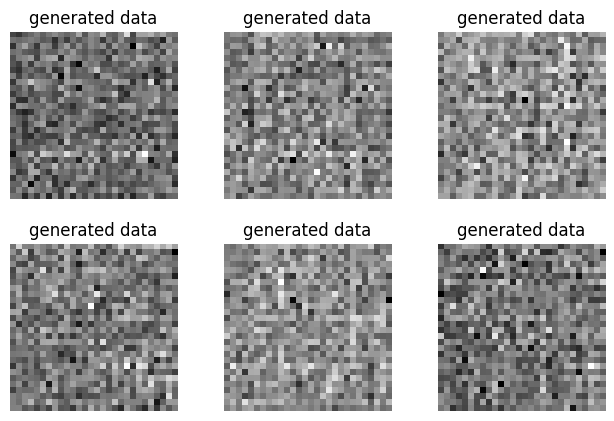

In [16]:
model.plot_img()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_v

Training: 0it [00:00, ?it/s]

epoch 0


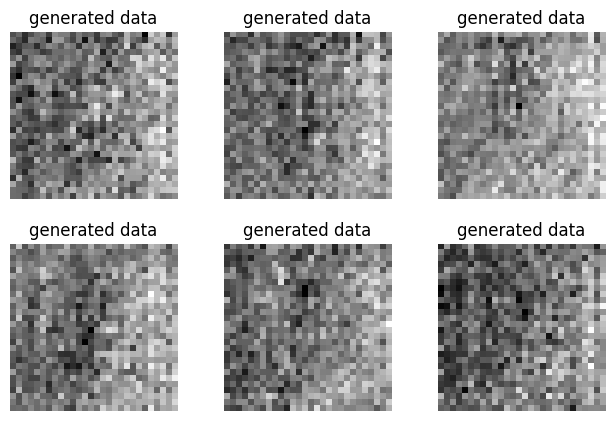

epoch 1


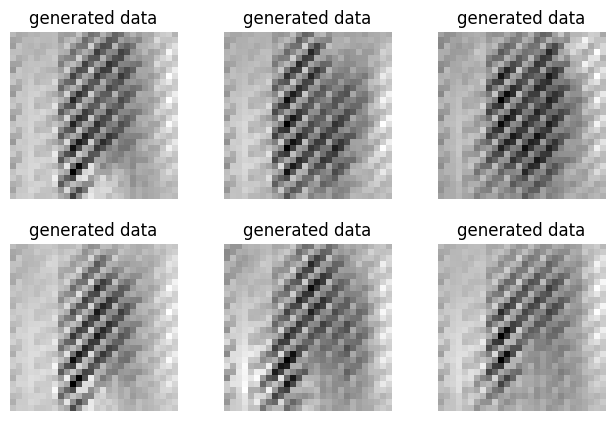

epoch 2


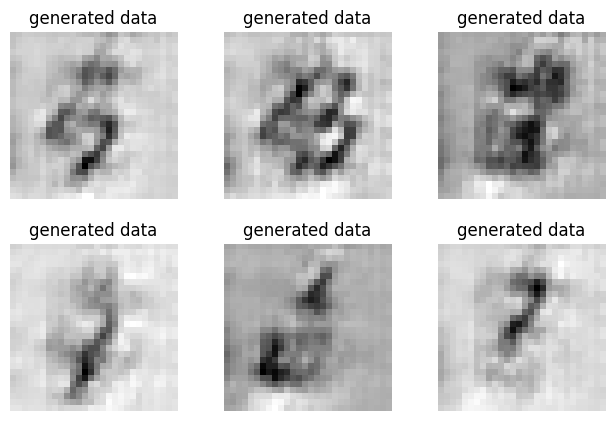

epoch 3


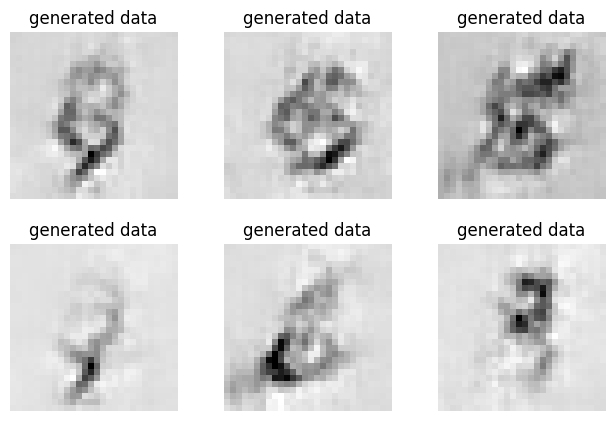

epoch 4


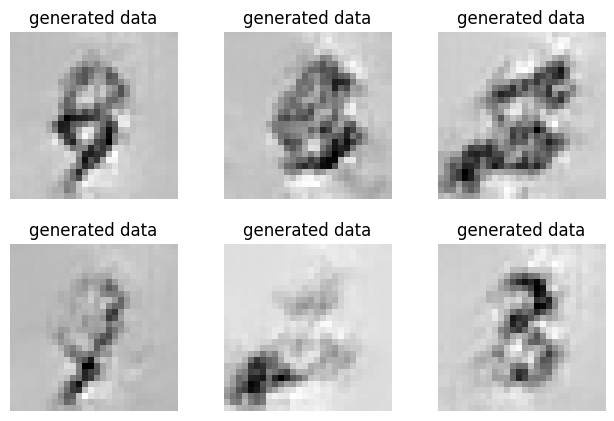

epoch 5


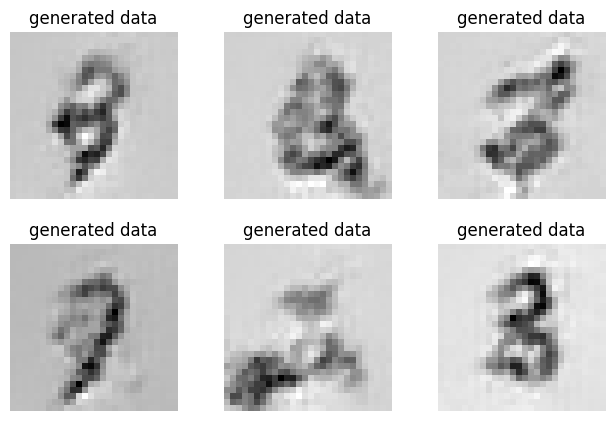

epoch 6


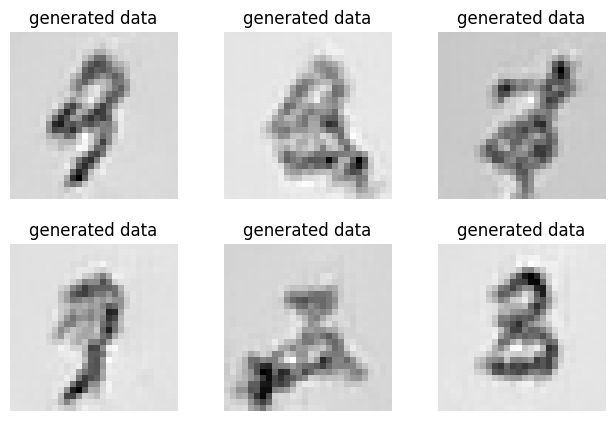

epoch 7


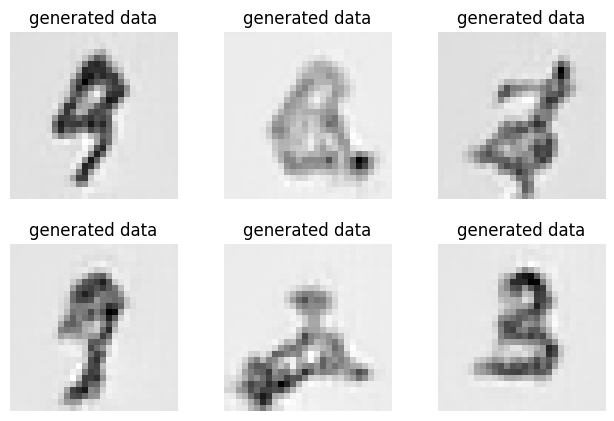

epoch 8


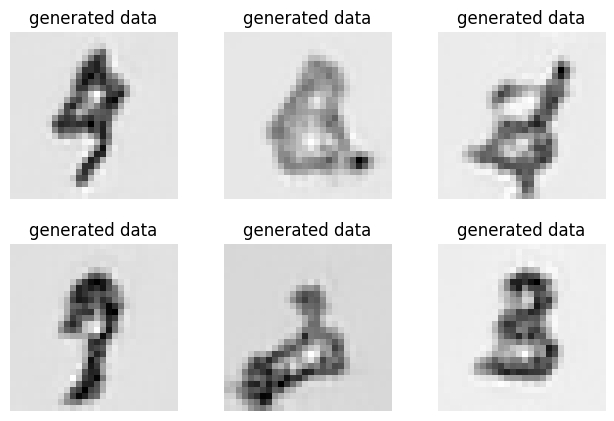

epoch 9


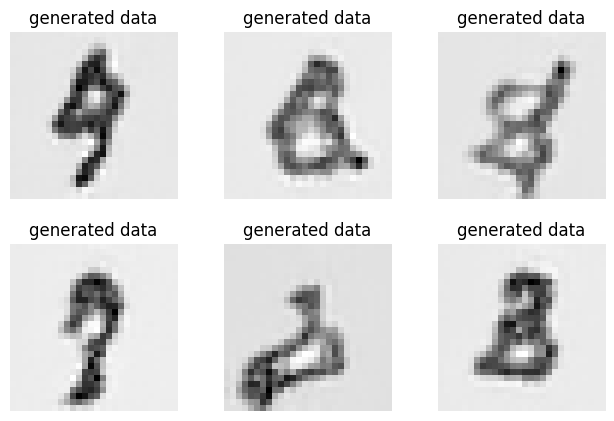

epoch 10


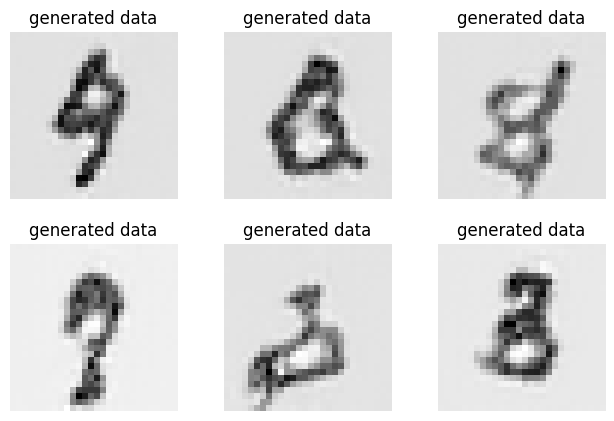

epoch 11


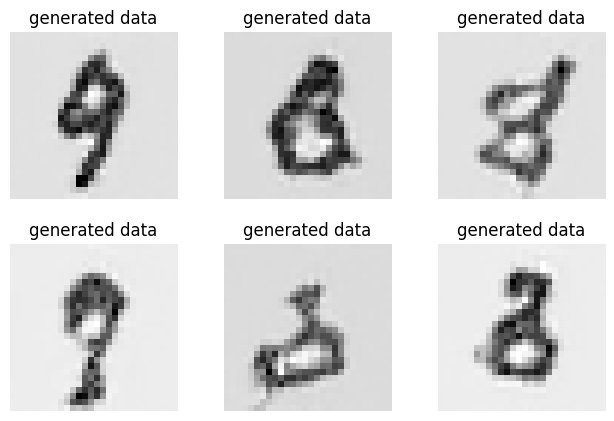

epoch 12


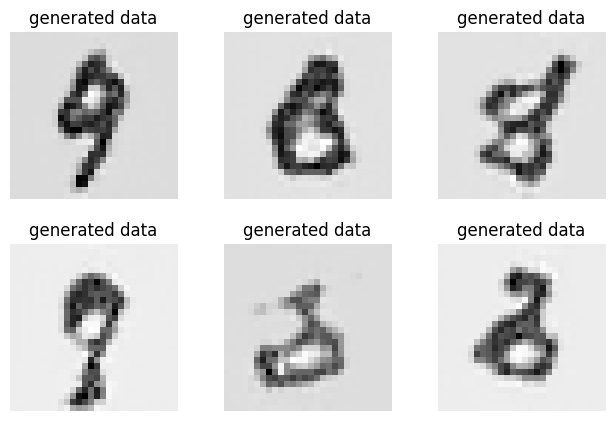

epoch 13


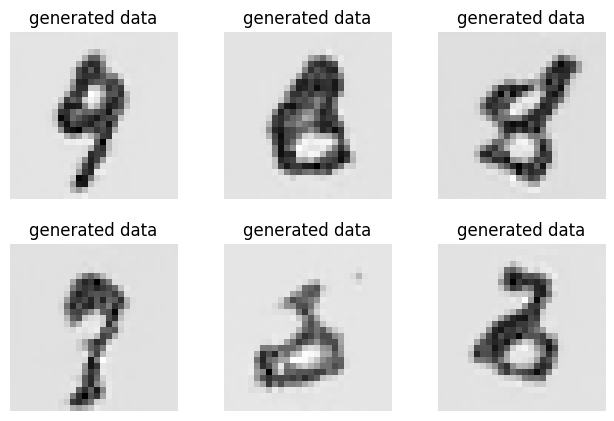

epoch 14


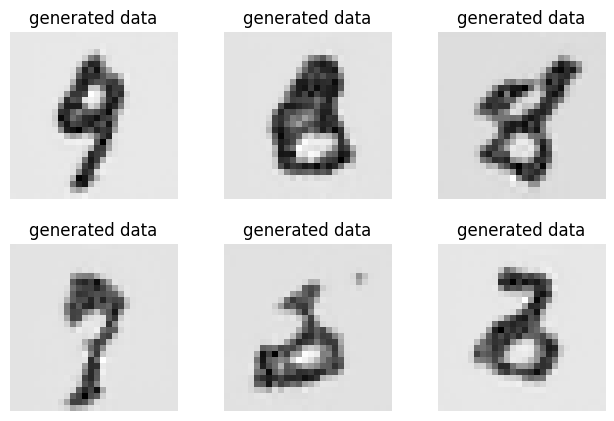

epoch 15


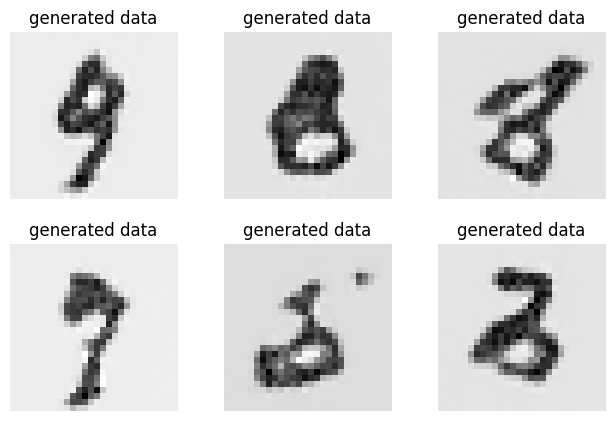

epoch 17


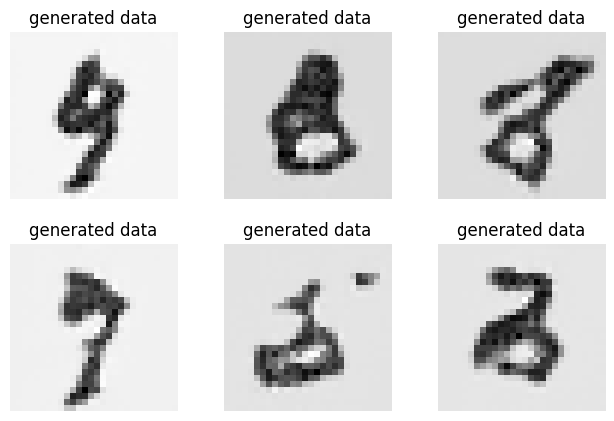

epoch 18


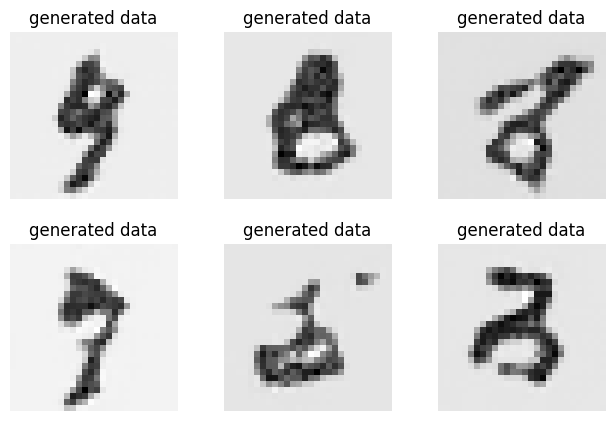

epoch 19


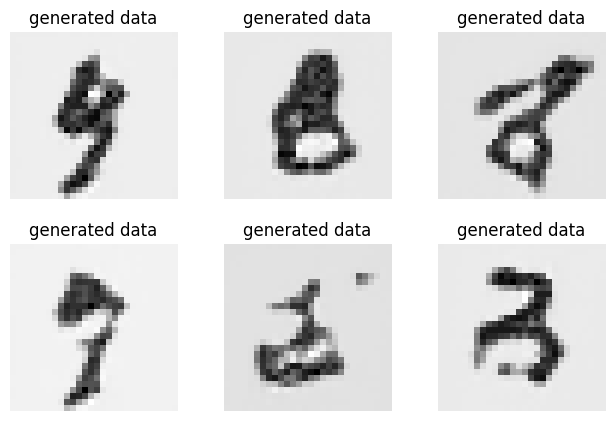

epoch 20


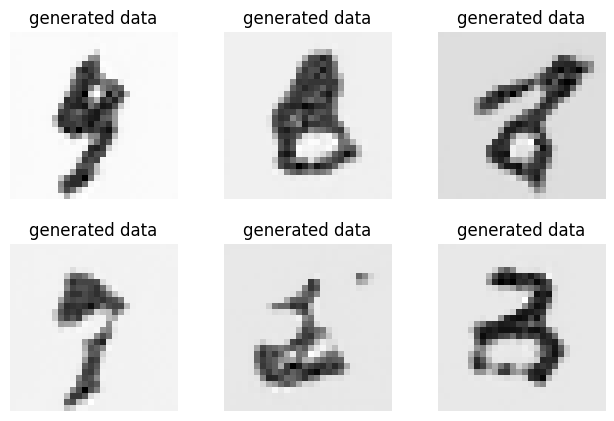

epoch 21


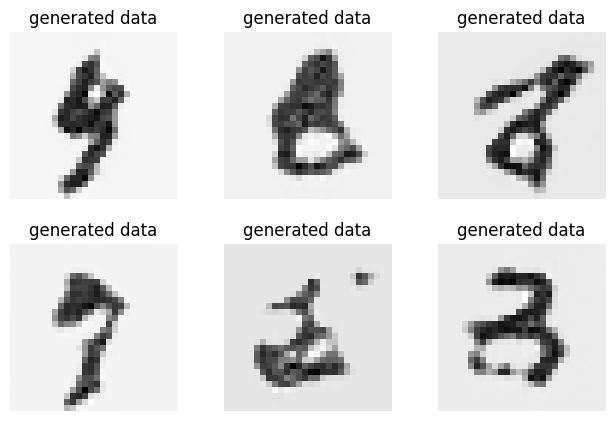

epoch 22


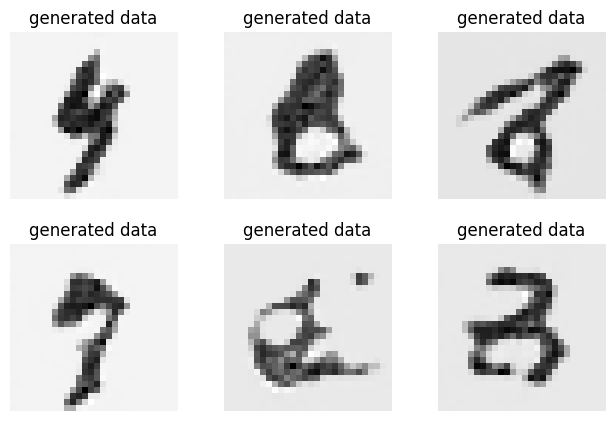

epoch 23


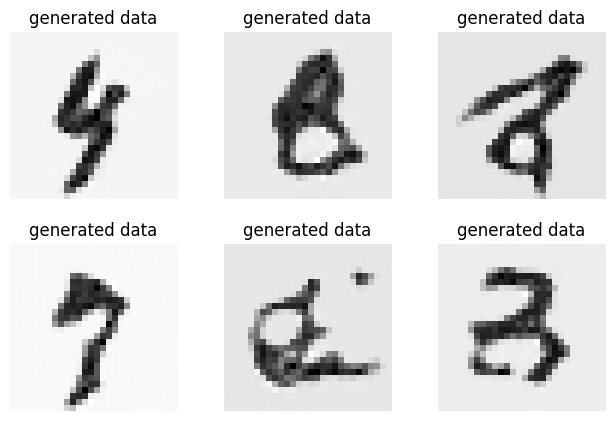

epoch 24


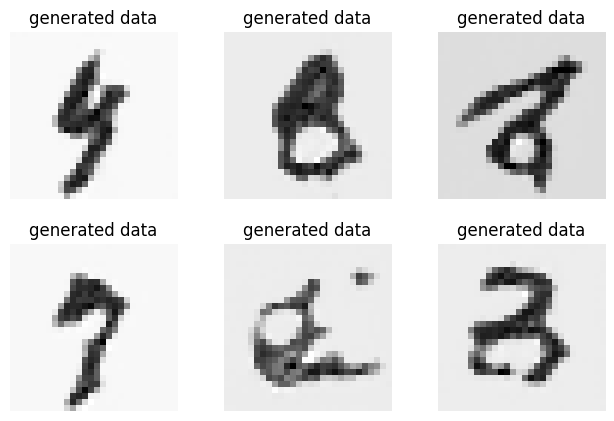

epoch 25


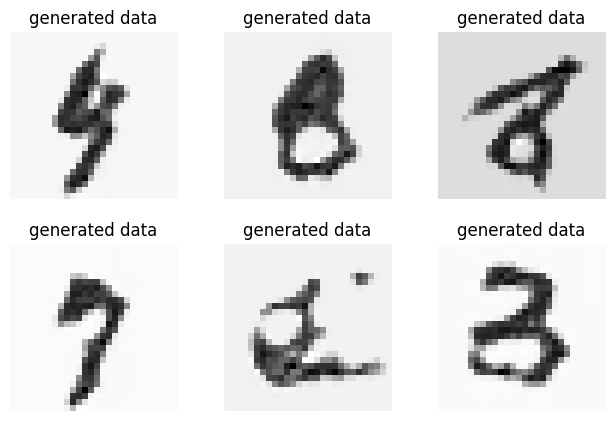

epoch 26


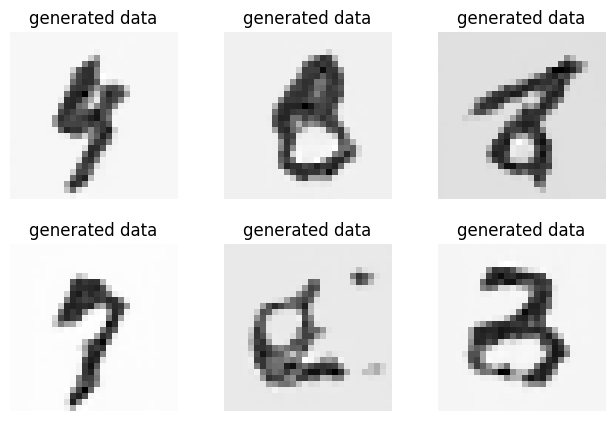

epoch 27


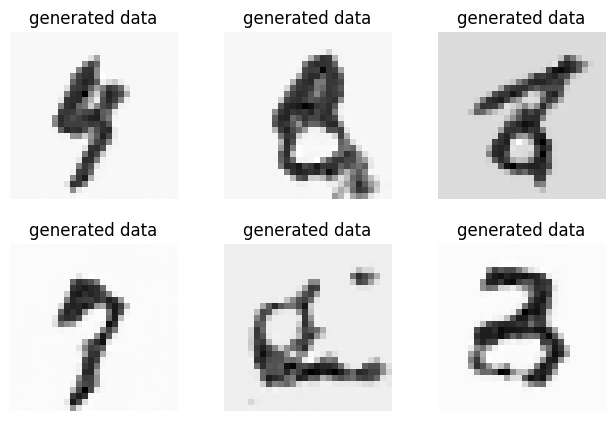

epoch 28


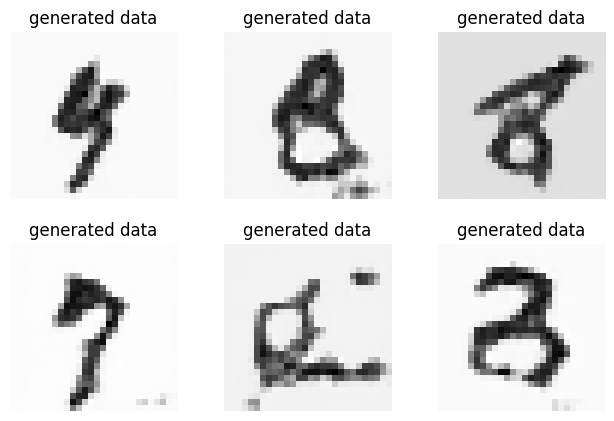

epoch 29


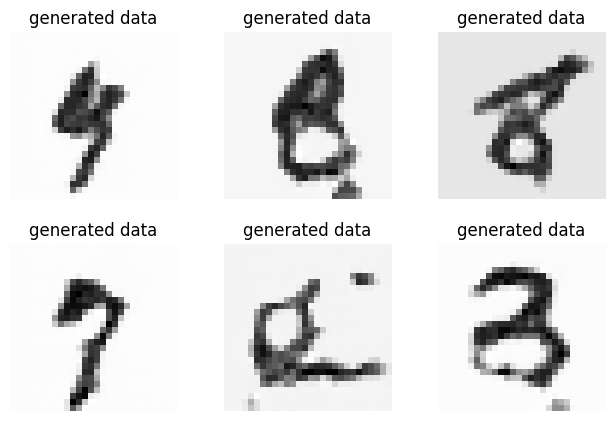

epoch 30


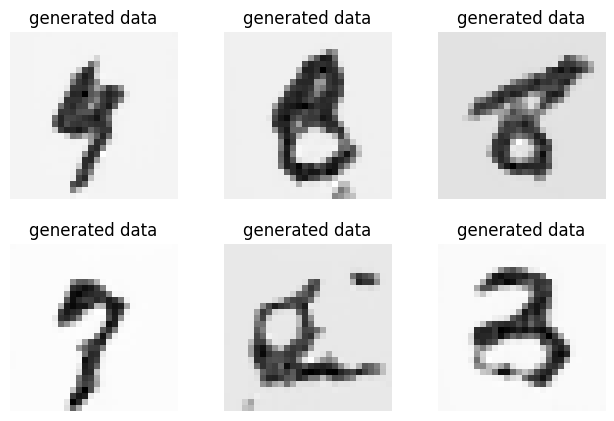

epoch 31


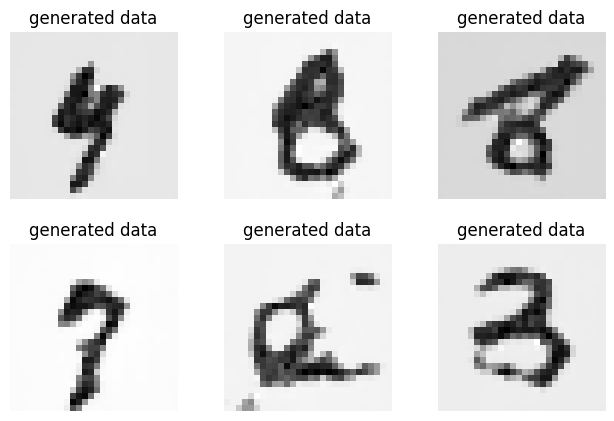

epoch 32


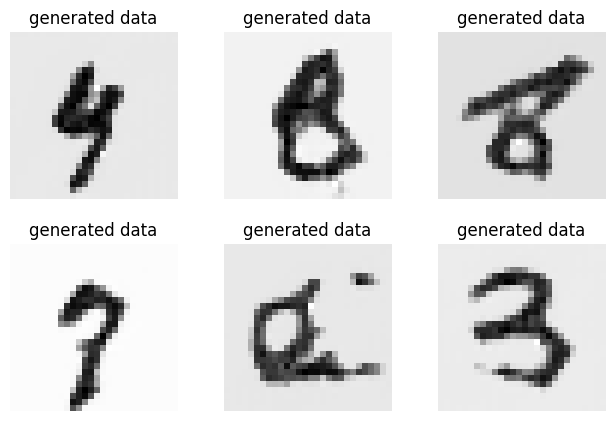

epoch 33


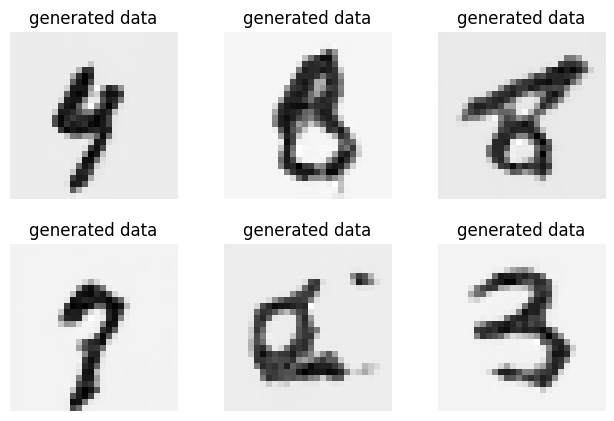

epoch 34


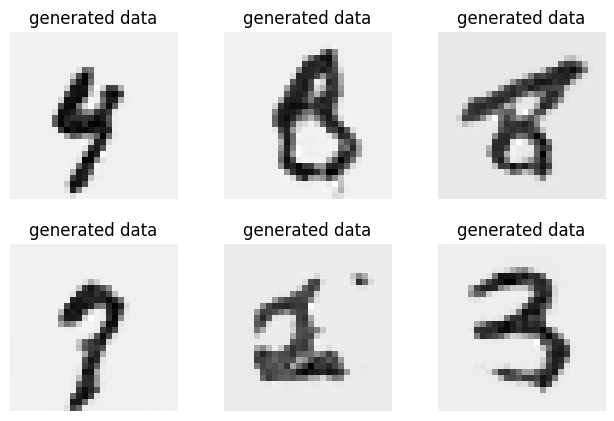

epoch 35


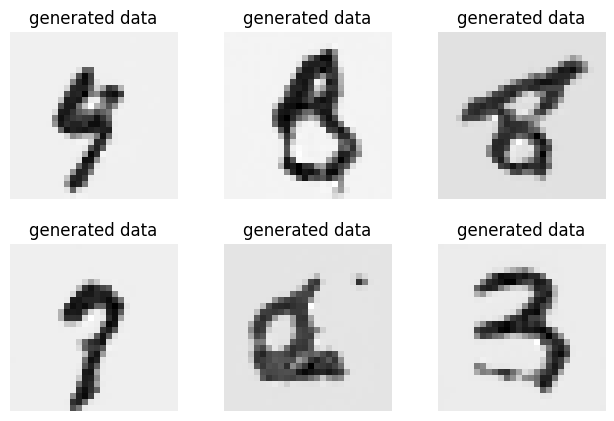

epoch 36


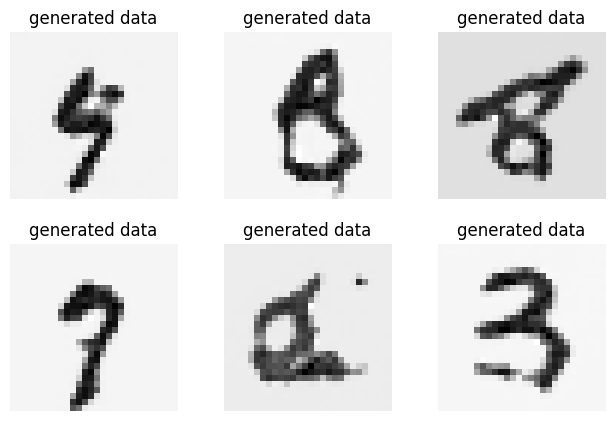

epoch 37


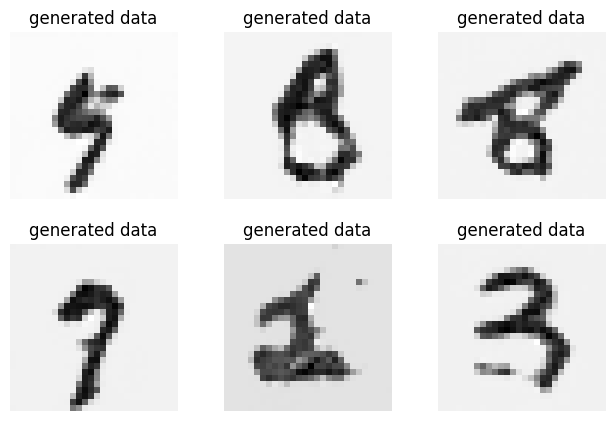

epoch 38


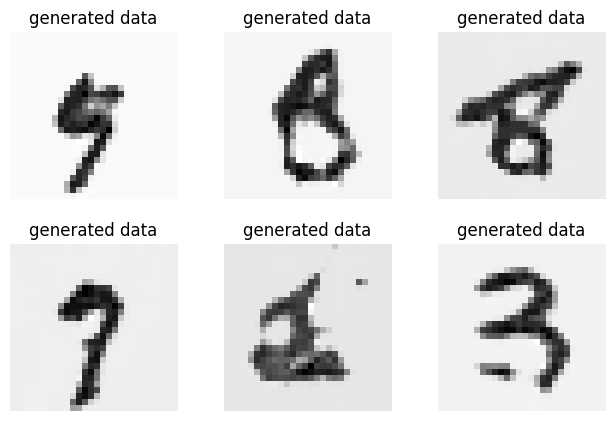

epoch 39


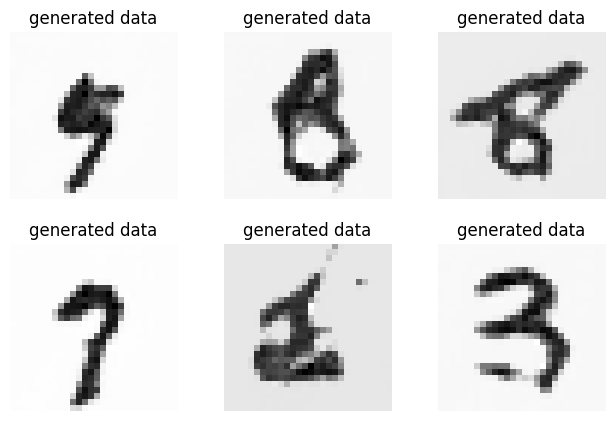

epoch 40


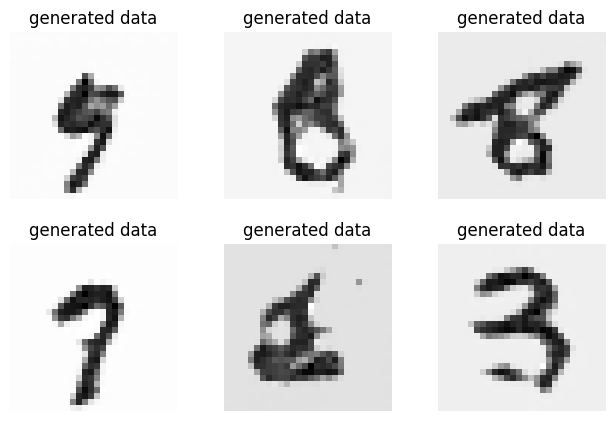

epoch 41


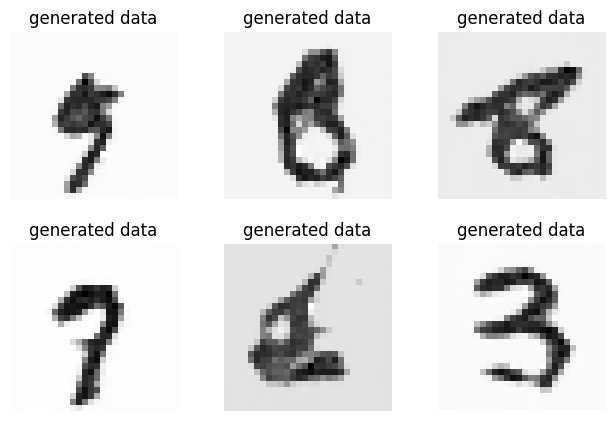

epoch 42


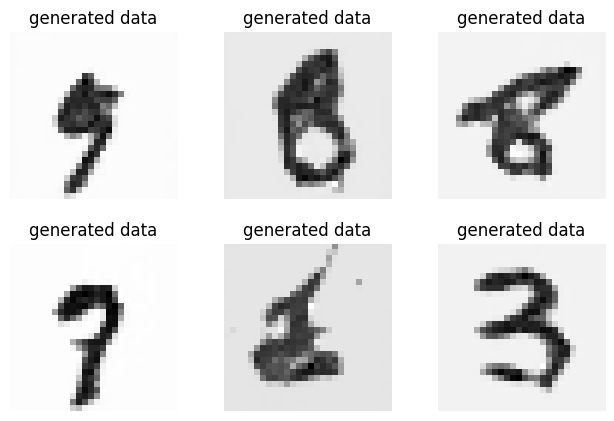

epoch 43


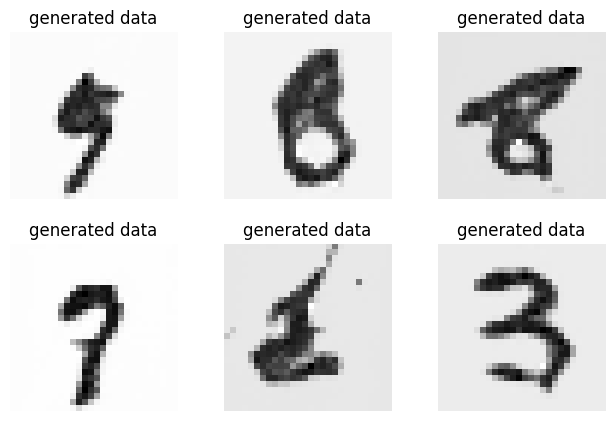

epoch 44


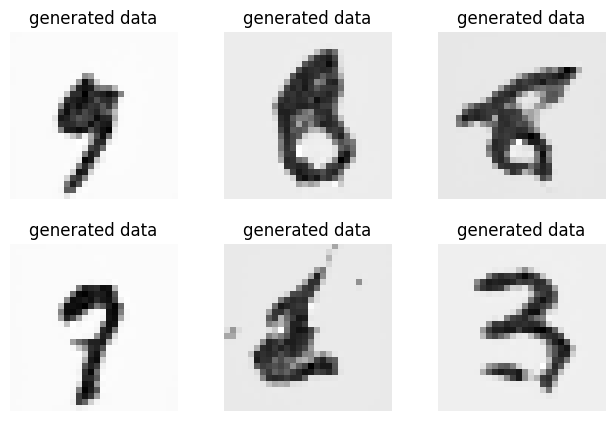

epoch 45


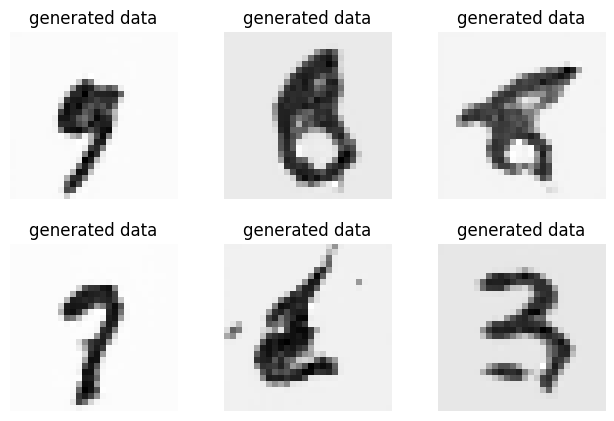

epoch 46


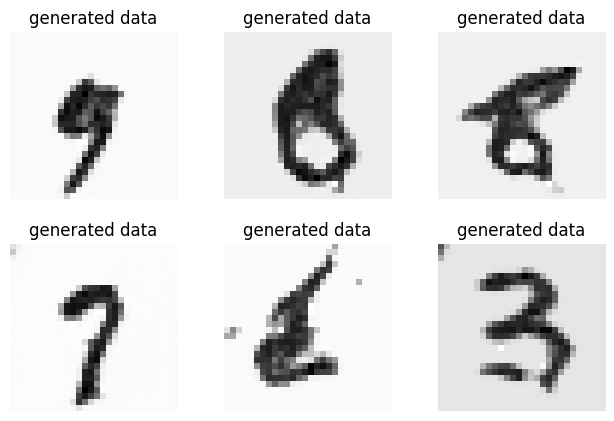

epoch 47


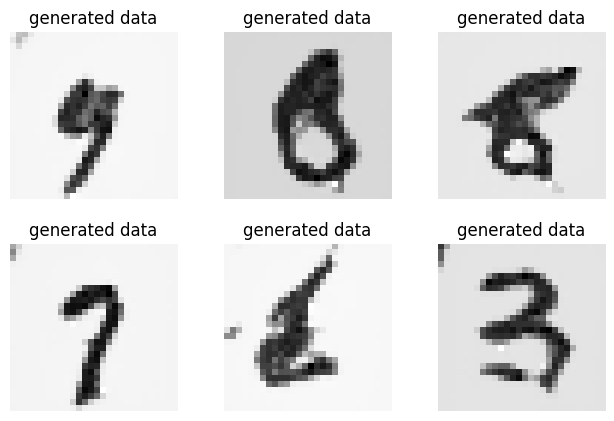

epoch 48


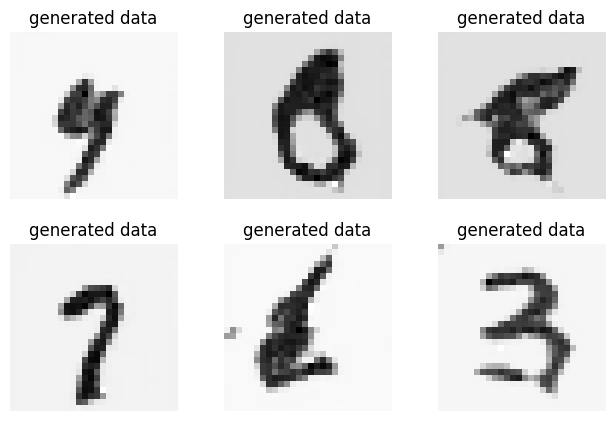

epoch 49


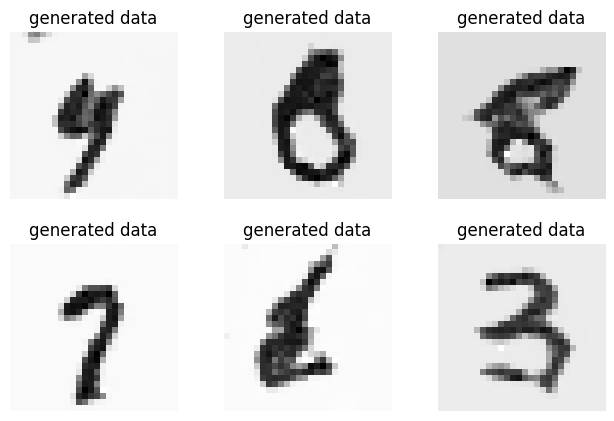

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [17]:
trainer = pl.Trainer(max_epochs=50, gpus=AVAIL_GPUS)
trainer.fit(model, dm)